In [1]:
from ipytables import *

In [2]:
import pylab as pl
%matplotlib inline
pl.rcParams['figure.figsize'] = 10, 5


In [3]:
import itertools
import os.path
import csv
import numpy as np
import scipy.spatial
import pandas as pd
pd.options.display.max_rows=20
pd.options.display.max_seq_items = 100
pd.options.display.max_colwidth = 100

In [4]:
try:
    #os.chdir("prepared_corpora/opinosis/")
    os.chdir("prepared_corpora/msrp/")
except FileNotFoundError:
    pass

In [5]:
def load_pf_group_index():
    df = pd.read_csv("./phrase_groups.csv")
    df.set_index(["paraphrase_group_index", "phrase_index"], inplace=True)
    return df
    

In [6]:
df = load_pf_group_index()
df["tokenized_phrases"]=[line.strip() for line in open("tokenized_phrases.txt","r")]


In [7]:
df["pvdm"]=list(np.loadtxt("outVectors_wiki_sentence_concat_pvdm.csv", delimiter=","))
df["dbow"]=list(np.loadtxt("outVectors_wiki_sentence_dbow.csv", delimiter=","))
df["urae"]=list(np.loadtxt("outVectors_RAE2011.csv", delimiter=","))
df["mowe"]=list(np.loadtxt("outVectors_mowe.csv", delimiter=","))
#df["sowe"]=list(np.loadtxt("outVectors_sowe.csv", delimiter=","))
#df["howe"]=list(np.loadtxt("outVectors_howe.csv", delimiter=","))
df["bow"]=list(np.loadtxt("outVectors_bow.csv", delimiter=","))


In [8]:
from sklearn.decomposition import PCA
df["pca_bow"] = list(PCA(300, whiten=False).fit_transform(np.row_stack(list(df.bow))))
#df["pca_howe"] = list(PCA(300, whiten=False).fit_transform(np.row_stack(list(df.howe))))

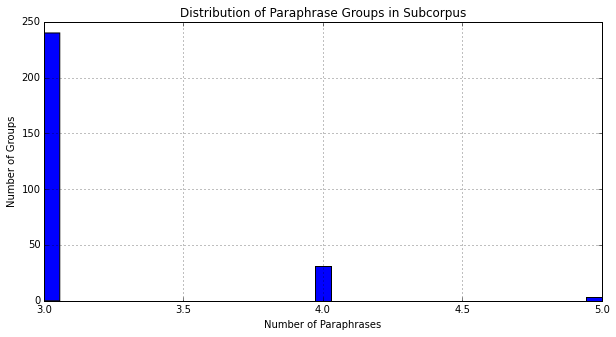

In [9]:
ax=df.tokenized_phrases.groupby(level=0).agg(len).hist(bins=35)

pl.title("Distribution of Paraphrase Groups in Subcorpus")
pl.xlabel("Number of Paraphrases")
pl.ylabel("Number of Groups")

In [ ]:
#Just consider paraphrase groups of a certain size
#df = df.groupby(level=0).filter(lambda group: len(group)>3)

In [10]:
for base in "pvdm dbow urae".split():
    df[base+"_bow"] = df[base].combine(df.bow, func=lambda a,b: np.concatenate((a,b)))
#    df["pca_"+base+"_bow"] = list(PCA(300, whiten=False).fit_transform(np.row_stack(df[base+"_bow"])))


In [ ]:
from sklearn.manifold import t_sne
def plot_tsne(column):
    tsne = t_sne.TSNE()
    Ys = tsne.fit_transform(np.row_stack(df[column]))
    
    pl.scatter(Ys[:,0],Ys[:,1], c=colors)
    pl.title = column
    
    

#Wei's method

0. Normalise all embeddings for each model
1. within each paraphrase group, for each model, work out average pair-wise cosine similarity (or distance)
  1. the ground truth in this case should be horizontal x axis, which means the best values that each model gets should be close to zero (if you use similarity, rather than distance). So the model with an overall trend of low similarity values capture the semantics better.
2. treat each model's average similarity/distance for the paraphrase groups as a time series, do a z-normalisation () the time (horizontal) axis is the paraphrase group index, and the y axis is the similarity value after the z-normalisation
3. measure the similarity between the four model time series, pair-wise using Euclidean distance to see which model agrees with each other. 


In [11]:
import scipy.spatial.distance as distance

def angular_dist(a,b):
    cos_sim = np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return 1- np.arccos(cos_sim)/np.pi


In [12]:
def get_std(series):
    xs=np.row_stack(series)
    std_dev = xs.std(axis=0)
    std_dev[std_dev==0.0]=1.0
    return list(std_dev)
def get_mean(series):
    xs = np.row_stack(series)
    return list(xs.mean(axis=0))

dfs = (df.iloc[:,1:]-df.iloc[:,1:].apply(get_mean))/df.iloc[:,1:].apply(get_std)



,pvdm,dbow,urae,mowe,bow,pca_bow,pvdm_bow,dbow_bow,urae_bow
count,274.000000,274.000000,273.000000,266.000000,274.000000,273.000000,274.000000,274.000000,274.000000
mean,0.734888,0.690109,0.666851,0.832070,0.720270,0.802577,0.719388,0.712539,0.715078
std,0.090541,0.050233,0.128158,0.055467,0.082145,0.065529,0.076964,0.073656,0.078476
min,0.431927,0.562660,0.445861,0.643534,0.533345,0.599647,0.550076,0.539077,0.535312
25%,0.671012,0.656412,0.558436,0.789510,0.661291,0.765021,0.666811,0.662776,0.661046
50%,0.741464,0.691663,0.646547,0.834854,0.722160,0.813340,0.722473,0.714318,0.717657
75%,0.804842,0.720590,0.754324,0.873598,0.777225,0.851989,0.772748,0.769755,0.773276
max,0.911060,0.828869,0.982542,0.964598,0.962493,0.932521,0.910616,0.921086,0.916579


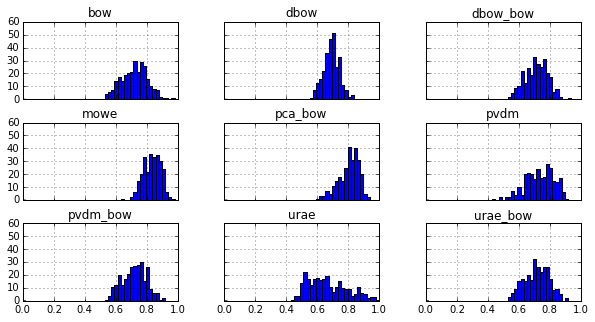

In [13]:
def get_group_sim(group):
    xs = np.row_stack(group)
    #cosine_sim = (1-distance.pdist(xs, 'cosine'))
    dist = distance.pdist(xs,angular_dist)
    return dist.mean()

group_sims = dfs.groupby(level=0).agg(get_group_sim)
group_sims.hist(bins=np.linspace(0,1,50), sharex=True, sharey=True)
group_sims.describe()

               pvdm       dbow  urae  mowe        bow  pca_bow   pvdm_bow  \
pvdm       0.000000  17.879404   NaN   NaN  18.518283      NaN  16.856726   
dbow      17.879404   0.000000   NaN   NaN  16.988055      NaN  16.556643   
urae            NaN        NaN     0   NaN        NaN      NaN        NaN   
mowe            NaN        NaN   NaN     0        NaN      NaN        NaN   
bow       18.518283  16.988055   NaN   NaN   0.000000      NaN   2.277373   
pca_bow         NaN        NaN   NaN   NaN        NaN        0        NaN   
pvdm_bow  16.856726  16.556643   NaN   NaN   2.277373      NaN   0.000000   
dbow_bow  18.200378  15.795953   NaN   NaN   1.998854      NaN   2.562600   
urae_bow  18.258139  16.824829   NaN   NaN   1.696700      NaN   2.482885   

           dbow_bow   urae_bow  
pvdm      18.200378  18.258139  
dbow      15.795953  16.824829  
urae            NaN        NaN  
mowe            NaN        NaN  
bow        1.998854   1.696700  
pca_bow         NaN        NaN 

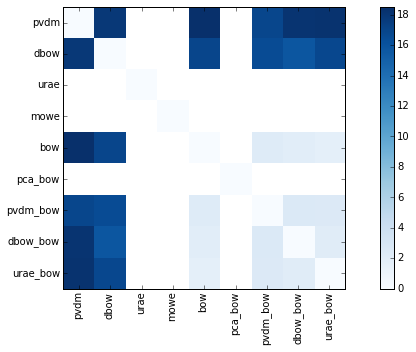

In [14]:
import matplotlib.cm as cm
def plot_matrix(cm, labels, cmap=cm.Blues):
    pl.imshow(cm, interpolation='nearest', cmap=cmap)
    pl.colorbar()
    tick_marks = np.arange(len(labels))
    pl.xticks(tick_marks, labels, rotation=90)
    pl.yticks(tick_marks, labels)
    pl.tight_layout()
    
def get_interrater_e_distance(ratings):
    rating_dist = distance.pdist(n_group_sims.as_matrix().T)
    return distance.squareform(rating_dist)

def z_norm(col):
    return (col-col.mean())/col.std()

n_group_sims = group_sims.apply(z_norm)


interrater_e_distance = get_interrater_e_distance(n_group_sims)
print(pd.DataFrame( interrater_e_distance, columns =n_group_sims.columns, index=n_group_sims.columns))
      
plot_matrix(interrater_e_distance, n_group_sims.columns)

In [15]:
def get_centroid(group):
    xs = np.row_stack(group)
    return list(xs.mean(axis=0)) #Euclidean



def get_medoid(group):
    points=np.row_stack(group)
    ingroup_index = distance.cdist(points,points, 'cosine').sum(axis=1).argmin()
    return list(points[ingroup_index,:])


def get_angular_centroid(group):
    # the angular centroid is a line, here we choes an arbitairy point on it.
    # Dicussion of how normalising and adding wroks is at http://math.stackexchange.com/a/925659/1505
    points = np.row_stack(group)
    unit_points = points/np.linalg.norm(points,axis=1)[:,None]  #Normalise ot unit vectors
    return list(np.sum(unit_points,axis=0))
    

def get_group_medoids(series):
    return series.groupby(level=0).agg(get_medoid)


def get_group_centroids(series):
    return series.groupby(level=0).agg(get_centroid)


In [24]:
def dunn_index(series):
    group_intra_distance = series.groupby(level=0).agg(get_group_sim)
    denom = group_intra_distance.max()
    group_ids = np.unique(series.index[0])
    
    for ii in group_ids:
        smallest_inter_dist = np.Inf
        for jj in group_ids:
            if ii==jj:
                continue
            #Now to find the Interclass distance
            #Lets
            Not WRITEN YET

    
    return denom

dunn_index(df.urae)

SyntaxError: invalid syntax (<ipython-input-24-dd822e254ad9>, line 13)

In [ ]:

#Davies-Bouldin Index 
#Modified to use angular centroid, and angular distance

def davied_bouldin_index(series):

    def av_dist_to_centroid(group):
        xs = np.row_stack(group)
        c = get_angular_centroid(group)
        return distance.cdist(xs,[c], angular_dist).mean()

    group_centroids = get_group_centroids(series)
    group_spreads = series.groupby(level=0).agg(av_dist_to_centroid)
    
    n_groups = len(group_spreads)
    
    total = 0.0
    for ii in range(n_groups):
        greatest = -1*np.Inf
        for jj in range(n_groups):
            if ii==jj:
                continue

            numer = group_spreads.iloc[ii] + group_spreads.iloc[jj] 
            denom = angular_dist(group_centroids.iloc[ii],group_centroids.iloc[jj])
            value = numer/denom
            greatest = max(greatest, value)
        total+= greatest
    return total/n_groups

            
for column in df.columns[1:]:
    print(column + " " + str(davied_bouldin_index(df.loc[:,column])))

In [16]:
def get_true_classes(series):
    return np.asarray([ii[0] for ii in series.index])

In [26]:
def get_classes_about_center(series, center_fun):
    group_centers = np.row_stack(series.groupby(level=0).agg(center_fun)) 
    points  = np.row_stack(series)
    class_indexes = distance.cdist(points,group_centers, 'cosine').argmin(axis=1)
    return np.asarray(series.index[class_indexes].labels[0])

def get_classes_by_similarity_to_true_classes(series):
    true_classes = get_true_classes(series)
    
    def av_dist_to_group(point, group):
        xs = np.row_stack(group)
        return distance.cdist(xs, [point], 'cosine').mean()
    
    return np.asarray([series.groupby(level=0).agg(lambda group: av_dist_to_group(point, group)).idxmin()
               for point in series])
    



def recluster_success(series):
    true_classes = get_true_classes(series)

    def get_acc(center_fun):
        classes = get_classes_about_center(series, center_fun)
        return (classes == true_classes).sum()/len(true_classes)
    
    classes = get_classes_by_similarity_to_true_classes(series)
    group_closeness_acc = (classes == true_classes).sum()/len(true_classes)

    return pd.Series([get_acc(get_centroid),
                      get_acc(get_medoid),
                      get_acc(get_angular_centroid),
                      group_closeness_acc
                     ], index="centroid_acc medoid_acc angular_centroid_acc group_closeness_acc".split()) 
    

recluster_results = pd.DataFrame()
for column in df.columns[1:]:
    recluster_results[column] = recluster_success(df[column])

recluster_results

KeyboardInterrupt: 

In [ ]:
#Lets take a look at what mistakes are being made.
#We can look at the exemplary member of each class as a repressentitive,
#And can compare that for the class it was given to that for the class it should have been given

def get_exemplars(df, col_name, get_center_fun):
    series = df[col_name]
    def get_exemplar(group):
        c = get_center_fun(group)
        points=np.row_stack(group)
        ingroup_index = distance.cdist(points,[c], 'cosine').flatten().argmin()
        df_index = group.index[ingroup_index]
        return df.tokenized_phrases[df_index]
    
    return series.groupby(level=0).agg(get_exemplar)


def get_mistakes(df, col_name, get_center_fun=get_angular_centroid):
    group_exemplars = get_exemplars(df, col_name,get_center_fun)
    
    series = df[col_name]
    
    classes = get_classes(series, get_center_fun)
    
    return show_mistakes(df, classes, col_name, get_center_fun)


def show_mistakes(df, actual_classes, col_for_exemplar="bow", get_center_fun = get_angular_centroid):
    group_exemplars = get_exemplars(df, col_for_exemplar, get_center_fun)
    
    true_classes = get_true_classes(df)
    mistake_indexs = np.nonzero(actual_classes!=true_classes)
    
    ret = pd.DataFrame()
    ret["mistaken_texts"] = list(df.tokenized_phrases.iloc[mistake_indexs])
    ret["true_exemplar"] = list(group_exemplars[true_classes[mistake_indexs]])
    ret["actual_exemplar"] = list(group_exemplars[actual_classes[mistake_indexs]])
    
    return ret


In [ ]:
#show_mistakes(df, get_classes_by_similarity_to_true_classes(df.bow))

In [ ]:
#get_mistakes(df, "bow",get_angular_centroid)

In [17]:
from sklearn.svm import NuSVC, SVC, LinearSVC
from sklearn import tree
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

#class_weight = {key: 1/value for (key, value) in Counter(training_data.debate_type).items()}

def classify(column, classifier, train_data, test_data, train_labels, test_labels):
    train_data_X = np.row_stack(train_data[column])
    test_data_X = np.row_stack(test_data[column])

    classifier.fit(train_data_X, train_labels)
    
    return classifier.score(test_data_X, test_labels)


classifiers = [LinearSVC(class_weight="auto",  max_iter=20000), 
               LinearSVC(class_weight="auto",  max_iter=20000, C=10),
               LinearSVC(class_weight="auto",  max_iter=20000, C=100),
               #LinearSVC(class_weight="auto",  max_iter=20000, C=1000),
               #LinearSVC(class_weight="auto",  max_iter=20000, C=10000)
       #SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=10),
       #SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=100),        
       #SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=1000),
       #SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=10000),
       #SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=100000),
       #SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=1000000),
        #OneVsRestClassifier(SVC(class_weight="auto",  max_iter=20000, kernel='rbf')),
        #tree.DecisionTreeClassifier(class_weight="auto")
        
        
       ]


In [18]:
from sklearn import cross_validation
n_folds = df.tokenized_phrases.groupby(level=0).agg(len).min()
print(str(n_folds)+"-fold validation")
classify_results = pd.DataFrame(index=classifiers)
for column in df.columns[1:]:
    for classifier in classifiers:
        cv_res = cross_validation.cross_val_score(classifier, 
                                          X = np.row_stack(df[column]),
                                          y = get_true_classes(df),
                                          cv=df[column].groupby(level=0).agg(len).min(),
                                          n_jobs=-1
                                        
                                          )
        classify_results.loc[classifier,(column)] = cv_res.mean()
        #classify_results.loc[svm,(column+"_std")] = cv_res.std()

classify_results

3-fold validation


,pvdm,dbow,urae,mowe,bow,pca_bow,pvdm_bow,dbow_bow,urae_bow
"LinearSVC(C=1.0, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=20000,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",0.603837,0.899325,0.500057,0.974429,0.983719,0.986018,0.983719,0.983719,0.983719
"LinearSVC(C=10, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=20000,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",0.774329,0.887870,0.508836,0.979134,0.983719,0.980217,0.983719,0.983719,0.983719
"LinearSVC(C=100, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=20000,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",0.779969,0.885450,0.495991,0.977918,0.983719,0.977918,0.983719,0.983719,0.983719


In [19]:
classify_results.max()

pvdm        0.779969
dbow        0.899325
urae        0.508836
mowe        0.979134
bow         0.983719
pca_bow     0.986018
pvdm_bow    0.983719
dbow_bow    0.983719
urae_bow    0.983719
dtype: float64

In [ ]:
def get_symetry_measure(group):
    xs = np.row_stack(group)
    dist=distance.pdist(xs, angular_dist)
    c=get_angular_centroid(xs)
    dist = distance.cdist(xs, [c],angular_dist)
    return dist.std()

df.groupby(level=0).agg(get_symetry_measure).describe()
    

In [31]:
def portion_of_points_on_bounding_box(group):
    xs = np.row_stack(group)
    on_max_border = np.any(xs==xs.max(axis=0), axis=1)
    on_min_border = np.any(xs==xs.min(axis=0), axis=1)
    on_border = on_min_border + on_max_border
    return ( on_border.sum()/len(group))

In [33]:
def unit_norms(vectors):
    vecs = np.row_stack(vectors)
    unit_norms = np.linalg.norm(vecs,axis=1)
    return unit_norms#[list(row) for row in unit_vecs]

dfa = pd.DataFrame(index=df.index, columns="bow pvdm dbow mowe urae".split())
for col in dfa.columns:
    dfa.loc[:,col]=df.loc[:,col]/unit_norms(df.loc[:,col])

dfa


KeyError: 'the label [urae] is not in the [columns]'

In [34]:
df.groupby(level=0).agg(portion_of_points_on_bounding_box).describe()

,pvdm,dbow,mowe,bow,pca_bow,pvdm_bow,dbow_bow
count,274,274,274,274,274,274,274
mean,1,1,1,1,1,1,1
std,0,0,0,0,0,0,0
min,1,1,1,1,1,1,1
25%,1,1,1,1,1,1,1
50%,1,1,1,1,1,1,1
75%,1,1,1,1,1,1,1
max,1,1,1,1,1,1,1


In [35]:
dfa.groupby(level=0).agg(portion_of_points_on_bounding_box).describe()

,bow,pvdm,dbow,mowe,urae
count,274,274,274,274,274
mean,1,1,1,1,0
std,0,0,0,0,0
min,1,1,1,1,0
25%,1,1,1,1,0
50%,1,1,1,1,0
75%,1,1,1,1,0
max,1,1,1,1,0


In [ ]:
def portion_where_angular_centroid_closer_than_average(group):
    c = get_angular_centroid(group)
    xs = np.row_stack(group)
    distances = distance.pdist(xs, 'cosine')
    av_dist = distances.mean()
    c_dist = distance.cdist(xs, [c],'cosine')
    return (c_dist<av_dist).sum()/len(group)
    
df.groupby(level=0).agg(portion_where_angular_centroid_closer_than_average).hist()

In [ ]:
group = [[1,0],[0,1]]
c = get_angular_centroid(group)
xs = np.row_stack(group)

In [ ]:
distance.pdist(xs, angular_dist)

In [ ]:
distance.cdist(xs, [c],'cosine')

In [ ]:
len(df.bow[(1,2)])